In [2]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git@nightly git+https://github.com/unslothai/unsloth-zoo.git

### Helper to compute loss & perplexity

In [3]:
import math, torch

def eval_perplexity(model, tokenizer, eval_dataset, max_samples=200, max_seq_length=1024, device="cuda"):
    model.eval()
    # model.to(device)
    losses = []

    # Infer device from any model parameter (works for 4-bit too)
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # No gradients for evaluation
    with torch.no_grad():
        for i in range(min(max_samples, len(eval_dataset))):
            text = eval_dataset[i]["text"]
            enc = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=max_seq_length,
            )
            enc = {k: v.to(device) for k, v in enc.items()}

            # Next-token prediction loss
            outputs = model(**enc, labels=enc["input_ids"])
            losses.append(outputs.loss.item())

    mean_loss = sum(losses) / len(losses)
    ppl = math.exp(mean_loss)
    return mean_loss, ppl

### Connect to Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load eval dataset

In [7]:
from datasets import load_from_disk

eval_dataset  = load_from_disk("/content/drive/MyDrive/llama_fine_tome_finetune/fineTome_eval")

### Evaluating the base llama 3.2 1B model

In [12]:
from unsloth import FastLanguageModel

max_seq_length = 2048
dtype = "bfloat16"   # or "float16" depending on your T4 support
load_in_4bit = True

base_model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = base_model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

from unsloth.chat_templates import get_chat_template
base_tokenizer = get_chat_template(base_tokenizer, chat_template="llama-3.1")

# storage for results
checkpoint_steps = []
checkpoint_losses = []
checkpoint_ppls = []

base_loss, base_ppl = eval_perplexity(
    base_model,
    base_tokenizer,
    eval_dataset,
    max_samples=200,
    max_seq_length=1024,
)
checkpoint_losses.append(base_loss)
checkpoint_ppls.append(base_ppl)
checkpoint_steps.append(0)

print("Base model:")
print("  eval loss      =", base_loss)
print("  eval perplexity =", base_ppl)


==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
cuda:0
Base model:
  eval loss      = 1.6926096227765084
  eval perplexity = 5.433641975165903


### Evaluating a fine-tuned model

In [13]:
from unsloth import FastLanguageModel

max_seq_length = 1024
dtype = None          # let Unsloth choose (or "float16")
load_in_4bit = True   # or False, depending how you trained

checkpoints = [180, 200, 220]
for cp in checkpoints:
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name      = f"/content/drive/MyDrive/llama_fine_tome_finetune/checkpoint-{cp}",   # the directory where you saved it
      max_seq_length  = max_seq_length,
      dtype           = dtype,
      load_in_4bit    = load_in_4bit,
  )

  from unsloth import FastLanguageModel
  FastLanguageModel.for_inference(model)  # optional, but recommended

  loss, ppl = eval_perplexity(
      model,
      tokenizer,
      eval_dataset,
      max_samples=200,
      max_seq_length=1024,
  )
  checkpoint_losses.append(loss)
  checkpoint_ppls.append(ppl)
  checkpoint_steps.append(cp)

  print(f"Fine-tuned model: {cp}")
  print("  eval loss      =", loss)
  print("  eval perplexity =", ppl)




==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.11.6 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


cuda:0
Fine-tuned model: 180
  eval loss      = 1.4624114850163459
  eval perplexity = 4.3163558154359825
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
cuda:0
Fine-tuned model: 200
  eval loss      = 1.4624385774135589
  eval perplexity = 4.31647275744636
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license


Generating plots...
✅ Graph saved to: /content/drive/MyDrive/llama_fine_tome_finetune/training_metrics_graph.png


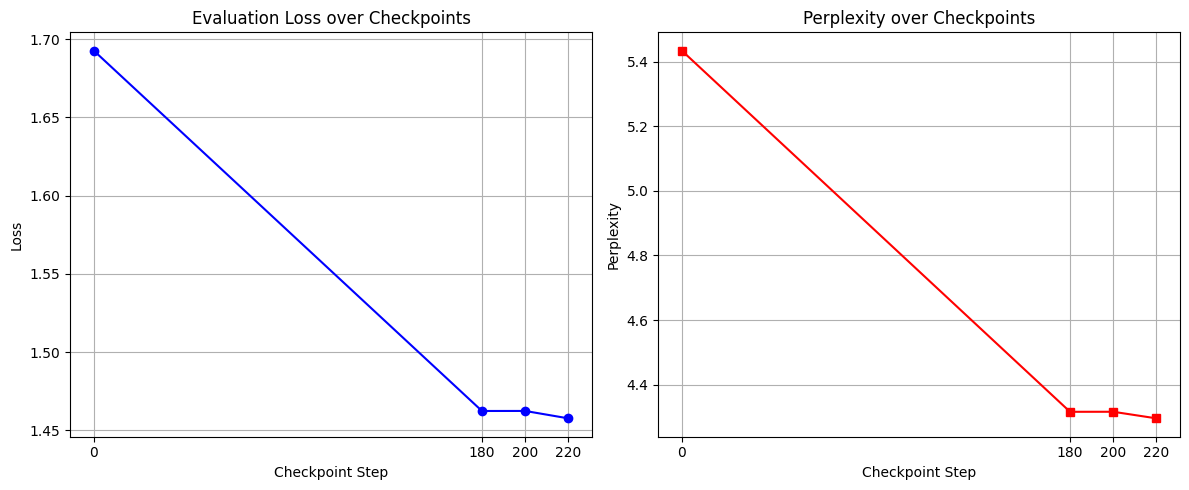

In [16]:
import matplotlib.pyplot as plt
import os

BASE_DIR = "/content/drive/MyDrive/llama_fine_tome_finetune/"

# --- PLOTTING ---
print("\nGenerating plots...")

if checkpoint_steps:
    plt.figure(figsize=(12, 5))

    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(checkpoint_steps, checkpoint_losses, marker='o', linestyle='-', color='b', label='Eval Loss')
    plt.title('Evaluation Loss over Checkpoints')
    plt.xlabel('Checkpoint Step')
    plt.ylabel('Loss')
    plt.xticks(checkpoint_steps) # Ensure 0, 180, 200, 220 are explicitly labeled
    plt.grid(True)

    # Plot 2: Perplexity
    plt.subplot(1, 2, 2)
    plt.plot(checkpoint_steps, checkpoint_ppls, marker='s', linestyle='-', color='r', label='Perplexity')
    plt.title('Perplexity over Checkpoints')
    plt.xlabel('Checkpoint Step')
    plt.ylabel('Perplexity')
    plt.xticks(checkpoint_steps)
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    output_file = os.path.join(BASE_DIR, "training_metrics_graph.png")
    plt.savefig(output_file)
    print(f"✅ Graph saved to: {output_file}")

    # Show plot (if in notebook)
    plt.show()
else:
    print("No data collected to plot.")